In [27]:
import pandas as pd
train_df = pd.read_parquet("/kaggle/input/asqadata/asqa_dev.parquet")



In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
train_df.head()

,ambiguous_question,qa_pairs,wikipages,annotations,sample_id
0,Who has the highest goals in world football?,"[{'context': 'No context provided', 'question'...",[{'title': 'International Federation of Footba...,"[{'knowledge': [], 'long_answer': 'Ali Dael ha...",-7013890438520559398
1,Who is the original artist of sound of silence?,[{'context': 'Sounds of Silence is the second ...,"[{'title': 'The Sound of Silence', 'url': 'htt...",[{'knowledge': [{'content': 'Wednesday Morning...,7089015503030534342
2,When was the first apple i phone made?,"[{'context': 'On January 9, 2007, Steve Jobs a...","[{'title': 'iPhone (1st generation)', 'url': '...",[{'knowledge': [{'content': 'The iPhone was re...,8793099883447006698
3,Who played the weasley brothers in harry potter?,[{'context': 'Richard Fish appeared as Bill br...,"[{'title': 'List of Harry Potter characters', ...",[{'knowledge': [{'content': 'Dozens of actors ...,-881464876144297194
4,How many state parks are there in virginia?,"[{'context': 'No context provided', 'question'...","[{'title': 'List of Virginia state parks', 'ur...",[{'knowledge': [{'content': 'Virginia opened i...,1650309494326541834


In [31]:
train_df.shape

(948, 5)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ambiguous_question  948 non-null    object
 1   qa_pairs            948 non-null    object
 2   wikipages           948 non-null    object
 3   annotations         948 non-null    object
 4   sample_id           948 non-null    object
dtypes: object(5)
memory usage: 37.2+ KB


In [33]:
train_df.isnull().sum()

ambiguous_question    0
qa_pairs              0
wikipages             0
annotations           0
sample_id             0
dtype: int64

In [34]:
train_df.columns

Index(['ambiguous_question', 'qa_pairs', 'wikipages', 'annotations',
       'sample_id'],
      dtype='object')

<Axes: >

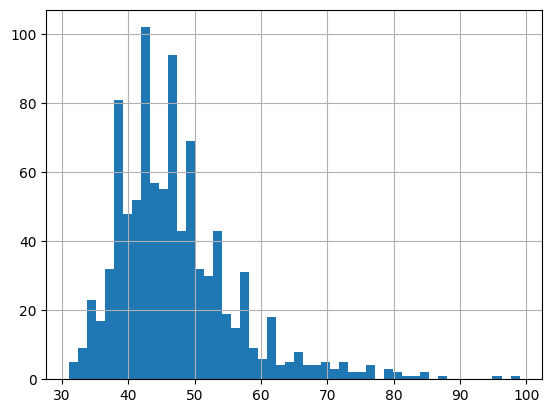

In [35]:
train_df["q_len"] = train_df["ambiguous_question"].str.len()
train_df["q_len"].hist(bins=50)


<Axes: >

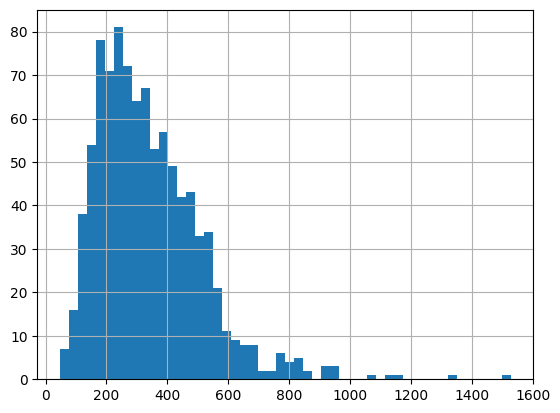

In [36]:
train_df["a_len"] = train_df["annotations"].apply(lambda x: len(x[0]["long_answer"]))
train_df["a_len"].hist(bins=50)


In [37]:
train_df["k_count"] = train_df["annotations"].apply(lambda x: len(x[0]["knowledge"]))
train_df["k_count"].value_counts().head()


k_count
1    364
0    252
2    178
3     78
4     43
Name: count, dtype: int64

In [39]:
def flatten_annotations(annotations):
    rows = []
    for i, ann in enumerate(annotations):
        knowledge = ann.get("knowledge", [])
        knowledge_strs = []
        for k in knowledge:
            if isinstance(k, dict) and "content" in k and k["content"]:
                knowledge_strs.append(k["content"])
        knowledge_str = "\n".join(knowledge_strs) if knowledge_strs else "[NO_KNOWLEDGE_AVAILABLE]"
        rows.append({
            "annotation_id": i,
            "long_answer": ann["long_answer"],
            "knowledge": knowledge_str,
        })
    return rows

def flatten_wikipages(wikipages):
    return "\n".join([f"{wp['title']}: {wp['url']}" for wp in wikipages])

def flatten_qa_pairs(qa_pairs):
    rows = []
    for qa in qa_pairs:
        short_answers = ", ".join(qa["short_answers"].tolist())
        rows.append({
            "sub_question": qa["question"],
            "short_answers": short_answers,
            "wikipage": qa.get("wikipage", np.nan),
        })
    return rows

# Apply flattening
flattened_data = []
for _, row in train_df.iterrows():
    annotations_flat = flatten_annotations(row["annotations"])
    wikipages_flat = flatten_wikipages(row["wikipages"])
    qa_pairs_flat = flatten_qa_pairs(row["qa_pairs"])
    for ann in annotations_flat:
        flattened_data.append({
            "sample_id": row["sample_id"],
            "ambiguous_question": row["ambiguous_question"],
            "annotation_id": ann["annotation_id"],
            "long_answer": ann["long_answer"],
            "knowledge": ann["knowledge"],
            "wikipages": wikipages_flat,
            "qa_pairs": qa_pairs_flat,
        })

# Create DataFrame
flattened_df = pd.DataFrame(flattened_data)

# Explode qa_pairs and add qa_pair_id
flattened_df = flattened_df.explode("qa_pairs").reset_index(drop=True)
flattened_df["qa_pair_id"] = flattened_df.groupby(["sample_id", "annotation_id"]).cumcount()

# Normalize qa_pairs
qa_df = pd.json_normalize(flattened_df["qa_pairs"])
flattened_df = pd.concat([flattened_df.drop("qa_pairs", axis=1), qa_df], axis=1)


In [40]:
flattened_df.head()

,sample_id,ambiguous_question,annotation_id,long_answer,knowledge,wikipages,qa_pair_id,sub_question,short_answers,wikipage
0,-7013890438520559398,Who has the highest goals in world football?,0,Ali Dael has the highest goals in men's world ...,[NO_KNOWLEDGE_AVAILABLE],International Federation of Football History &...,0,Who has the highest goals in men's world inter...,"Daei, Ali Daei",None
1,-7013890438520559398,Who has the highest goals in world football?,0,Ali Dael has the highest goals in men's world ...,[NO_KNOWLEDGE_AVAILABLE],International Federation of Football History &...,1,Who has the highest goals all-time in men's fo...,"Bican, Josef Bican",None
2,-7013890438520559398,Who has the highest goals in world football?,0,Ali Dael has the highest goals in men's world ...,[NO_KNOWLEDGE_AVAILABLE],International Federation of Football History &...,2,Who has the highest goals in women's world int...,"Sinclair, Christine Sinclair",List of women's footballers with 100 or more i...
3,-7013890438520559398,Who has the highest goals in world football?,1,The players with the highest all-time goals an...,Sinclair is the world's all-time leader for in...,International Federation of Football History &...,0,Who has the highest goals in men's world inter...,"Daei, Ali Daei",None
4,-7013890438520559398,Who has the highest goals in world football?,1,The players with the highest all-time goals an...,Sinclair is the world's all-time leader for in...,International Federation of Football History &...,1,Who has the highest goals all-time in men's fo...,"Bican, Josef Bican",None


In [41]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sample_id           6368 non-null   object
 1   ambiguous_question  6368 non-null   object
 2   annotation_id       6368 non-null   int64 
 3   long_answer         6368 non-null   object
 4   knowledge           6368 non-null   object
 5   wikipages           6368 non-null   object
 6   qa_pair_id          6368 non-null   int64 
 7   sub_question        6368 non-null   object
 8   short_answers       6368 non-null   object
 9   wikipage            2910 non-null   object
dtypes: int64(2), object(8)
memory usage: 497.6+ KB


In [42]:
flattened_df.isnull().sum()

sample_id                0
ambiguous_question       0
annotation_id            0
long_answer              0
knowledge                0
wikipages                0
qa_pair_id               0
sub_question             0
short_answers            0
wikipage              3458
dtype: int64

In [43]:
flattened_df = flattened_df.drop(columns=["wikipage"])


In [44]:
# Group by annotation_id and knowledge availability
groups = flattened_df.groupby([
    "annotation_id",
    flattened_df["knowledge"].apply(lambda x: "NO_KNOWLEDGE" if x == "[NO_KNOWLEDGE_AVAILABLE]" else "HAS_KNOWLEDGE")
])

# Sample proportionally from each group, but never more than available
sampled_df = groups.apply(lambda x: x.sample(min(5, len(x)), random_state=42))

# Separate rows with and without knowledge
no_knowledge = flattened_df[flattened_df["knowledge"] == "[NO_KNOWLEDGE_AVAILABLE]"]
has_knowledge = flattened_df[flattened_df["knowledge"] != "[NO_KNOWLEDGE_AVAILABLE]"]

# Sample up to 100 from no_knowledge and up to 300 from has_knowledge
no_knowledge_sample = no_knowledge.sample(min(100, len(no_knowledge)), random_state=42)
has_knowledge_sample = has_knowledge.sample(min(300, len(has_knowledge)), random_state=42)

# Combine and shuffle
final_sample = pd.concat([no_knowledge_sample, has_knowledge_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the subset
final_sample.to_csv("selected_400_samples.csv", index=False)

print(f"Subset shape: {final_sample.shape}")
final_sample.head()


Subset shape: (400, 9)


/tmp/ipykernel_36/2525033199.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = groups.apply(lambda x: x.sample(min(5, len(x)), random_state=42))


,sample_id,ambiguous_question,annotation_id,long_answer,knowledge,wikipages,qa_pair_id,sub_question,short_answers
0,6087617540935009990,When does halley's comet come back around?,1,"Halley's Comet or Comet Halley, officially des...","Halley's Comet or Comet Halley, officially des...",Halley's Comet: https://en.wikipedia.org/wiki/...,2,When is the period does halley's comet come ba...,every 75–76 years
1,6198433147510073269,Who produced toni braxton just be a man about it?,0,Teddy Bishop was the main producer for Toni Br...,"""Just Be a Man About It"" is a telephone breaku...",Just Be a Man About It: https://en.wikipedia.o...,3,"Who were the co producers of Toni Braxton's ""J...","Toni Braxton, Bryan-Michael Cox"
2,5650367261587015274,When did pakistan won olympic gold medal in ho...,0,Pakistan won their first Olympic gold medal in...,[NO_KNOWLEDGE_AVAILABLE],Pakistan at the Olympics: https://en.wikipedia...,0,When did Pakistan win an Olympic gold medal in...,1968
3,-2028008768314817948,Who is elected as the vice president of india?,0,The second highest constitutional office or th...,Bhairon Singh Shekhawat (23 October 1925 – 15 ...,List of vice presidents of India: https://en.w...,3,Who was elected as the Vice President of India...,Venkaiah Naidu
4,-7035938730030199426,Who used to be on the five on fox?,0,"Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",[NO_KNOWLEDGE_AVAILABLE],Jesse Watters: https://en.wikipedia.org/wiki/J...,0,"Who are the former hosts of ""The Five"" on Fox ...","Bob Beckel, Andrea Tantaros, Eric Bolling, Kim..."


In [45]:
final_sample.shape

(400, 9)

In [46]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the model and tokenizer
base_model = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(base_model, torch_dtype=torch.float16, device_map="auto")

def generate_llm_response(prompt, model, tokenizer, max_new_tokens=150):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    # Remove the prompt from the response to isolate the answer
    answer = response.replace(prompt, "").strip()
    return answer


question = "Who has the highest goals in world football?"
response = generate_llm_response(question, model, tokenizer)
print(response)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Miroslav Klose holds the record for the most goals in world football with 16 goals.


In [47]:
def construct_rag_prompt(row):
    # Parse wikipages string into a list of dictionaries
    wikipages = []
    if isinstance(row["wikipages"], str):
        for line in row["wikipages"].split("\n"):
            if ":" in line:
                title, url = line.split(":", 1)
                wikipages.append({"title": title.strip(), "url": url.strip()})

    # Use the knowledge field as context (since it contains the actual content)
    context = row["knowledge"]

    prompt = f"""
    Please answer the following question using only the context provided below.

    Context:
    {context}

    Question:
    {row["ambiguous_question"]}
    """
    return prompt


In [52]:
final_sample["rag_prompt"] = final_sample.apply(construct_rag_prompt, axis=1)
final_sample["llm_response"] = final_sample.apply(
    lambda row: generate_llm_response(row["rag_prompt"], model, tokenizer),
    axis=1
)



In [49]:
final_sample.head()

,sample_id,ambiguous_question,annotation_id,long_answer,knowledge,wikipages,qa_pair_id,sub_question,short_answers,rag_prompt
0,6087617540935009990,When does halley's comet come back around?,1,"Halley's Comet or Comet Halley, officially des...","Halley's Comet or Comet Halley, officially des...",Halley's Comet: https://en.wikipedia.org/wiki/...,2,When is the period does halley's comet come ba...,every 75–76 years,\n Please answer the following question usi...
1,6198433147510073269,Who produced toni braxton just be a man about it?,0,Teddy Bishop was the main producer for Toni Br...,"""Just Be a Man About It"" is a telephone breaku...",Just Be a Man About It: https://en.wikipedia.o...,3,"Who were the co producers of Toni Braxton's ""J...","Toni Braxton, Bryan-Michael Cox",\n Please answer the following question usi...
2,5650367261587015274,When did pakistan won olympic gold medal in ho...,0,Pakistan won their first Olympic gold medal in...,[NO_KNOWLEDGE_AVAILABLE],Pakistan at the Olympics: https://en.wikipedia...,0,When did Pakistan win an Olympic gold medal in...,1968,\n Please answer the following question usi...
3,-2028008768314817948,Who is elected as the vice president of india?,0,The second highest constitutional office or th...,Bhairon Singh Shekhawat (23 October 1925 – 15 ...,List of vice presidents of India: https://en.w...,3,Who was elected as the Vice President of India...,Venkaiah Naidu,\n Please answer the following question usi...
4,-7035938730030199426,Who used to be on the five on fox?,0,"Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",[NO_KNOWLEDGE_AVAILABLE],Jesse Watters: https://en.wikipedia.org/wiki/J...,0,"Who are the former hosts of ""The Five"" on Fox ...","Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",\n Please answer the following question usi...


In [50]:
final_sample.to_csv("llm_response_selected_400_samples.csv", index=False)

In [51]:
final_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sample_id           400 non-null    object
 1   ambiguous_question  400 non-null    object
 2   annotation_id       400 non-null    int64 
 3   long_answer         400 non-null    object
 4   knowledge           400 non-null    object
 5   wikipages           400 non-null    object
 6   qa_pair_id          400 non-null    int64 
 7   sub_question        400 non-null    object
 8   short_answers       400 non-null    object
 9   rag_prompt          400 non-null    object
dtypes: int64(2), object(8)
memory usage: 31.4+ KB


# LLM response- decoding

In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the T5-Flan Large model and tokenizer
model_path = "/kaggle/input/flan-t5/pytorch/large/3"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path, device_map="auto")


2025-09-16 05:46:19.353235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758001579.375501      80 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758001579.382276      80 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface

In [3]:
def construct_fact_extraction_prompt(text):
    prompt = f"""
    You are a helpful assistant that identifies atomic, verifiable facts from a paragraph of text.
    For each fact, list it as a separate bullet point.

    Example 1:
    Paragraph: "The Earth orbits the Sun once every 365.25 days. It is the third planet from the Sun."
    Facts:
    - The Earth orbits the Sun once every 365.25 days.
    - The Earth is the third planet from the Sun.

    Example 2:
    Paragraph: "Paris is the capital of France. It is known for the Eiffel Tower, which was completed in 1889."
    Facts:
    - Paris is the capital of France.
    - Paris is known for the Eiffel Tower.
    - The Eiffel Tower was completed in 1889.

    Now extract facts from the following paragraph:
    Paragraph: "{text}"
    Facts:
    """
    return prompt


In [4]:
def extract_atomic_facts(text, model, tokenizer):
    # Construct the prompt
    prompt = construct_fact_extraction_prompt(text)

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate the output
    output = model.generate(**inputs, max_length=512)

    # Decode the output
    facts = tokenizer.decode(output[0], skip_special_tokens=True)

    return facts


In [ ]:
# Extract atomic facts for each LLM response
final_sample["atomic_facts"] = final_sample["llm_response"].apply(
    lambda text: extract_atomic_facts(text, model, tokenizer)
)


In [ ]:
# Save the updated DataFrame with atomic facts
final_sample.to_csv("atomic_facts_llm_response_selected_400_samples.csv", index=False)


In [2]:
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Load the T5-Flan Large model and tokenizer
model_path = "/kaggle/input/flan-t5/pytorch/large/3"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path, device_map="auto")

# Function to construct the fact extraction prompt
def construct_fact_extraction_prompt(text):
    prompt = f"""
    You are a helpful assistant that identifies atomic, verifiable facts from a paragraph of text.
    For each fact, list it as a separate bullet point.

    Example 1:
    Paragraph: "The Earth orbits the Sun once every 365.25 days. It is the third planet from the Sun."
    Facts:
    - The Earth orbits the Sun once every 365.25 days.
    - The Earth is the third planet from the Sun.

    Example 2:
    Paragraph: "Paris is the capital of France. It is known for the Eiffel Tower, which was completed in 1889."
    Facts:
    - Paris is the capital of France.
    - Paris is known for the Eiffel Tower.
    - The Eiffel Tower was completed in 1889.

    Now extract facts from the following paragraph:
    Paragraph: "{text}"
    Facts:
    """
    return prompt

# Function to extract atomic facts using T5-Flan Large
def extract_atomic_facts(text, model, tokenizer):
    prompt = construct_fact_extraction_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_length=512)
    facts = tokenizer.decode(output[0], skip_special_tokens=True)
    return facts

# Apply the function to the DataFrame with a progress bar
final_sample["atomic_facts"] = final_sample["llm_response"].progress_apply(
    lambda text: extract_atomic_facts(text, model, tokenizer)
)

# Save the updated DataFrame

final_sample.to_csv("atomic_facts_llm_response_selected_400_samples.csv", index=False)


2025-09-16 05:53:12.463916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758001992.652588      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758001992.715575      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface

In [3]:
final_sample.head()

,sample_id,ambiguous_question,annotation_id,long_answer,knowledge,wikipages,qa_pair_id,sub_question,short_answers,rag_prompt,llm_response,atomic_facts
0,6087617540935009990,When does halley's comet come back around?,1,"Halley's Comet or Comet Halley, officially des...","Halley's Comet or Comet Halley, officially des...",Halley's Comet: https://en.wikipedia.org/wiki/...,2,When is the period does halley's comet come ba...,every 75–76 years,\n Please answer the following question usi...,Answer:\n Halley's Comet comes back around ...,Halley's Comet comes back around every 75-76 y...
1,6198433147510073269,Who produced toni braxton just be a man about it?,0,Teddy Bishop was the main producer for Toni Br...,"""Just Be a Man About It"" is a telephone breaku...",Just Be a Man About It: https://en.wikipedia.o...,3,"Who were the co producers of Toni Braxton's ""J...","Toni Braxton, Bryan-Michael Cox",\n Please answer the following question usi...,Answer:\n Dr. Dre,Dr. Dre is the answer.
2,5650367261587015274,When did pakistan won olympic gold medal in ho...,0,Pakistan won their first Olympic gold medal in...,[NO_KNOWLEDGE_AVAILABLE],Pakistan at the Olympics: https://en.wikipedia...,0,When did Pakistan win an Olympic gold medal in...,1968,\n Please answer the following question usi...,Answer:\n [NO_KNOWLEDGE_AVAILABLE],[NO_KNOWLEDGE_AVAILABLE]
3,-2028008768314817948,Who is elected as the vice president of india?,0,The second highest constitutional office or th...,Bhairon Singh Shekhawat (23 October 1925 – 15 ...,List of vice presidents of India: https://en.w...,3,Who was elected as the Vice President of India...,Venkaiah Naidu,\n Please answer the following question usi...,Answer:\n Bhairon Singh Shekhawat was elect...,- Bhairon Singh Shekhawat was elected as the v...
4,-7035938730030199426,Who used to be on the five on fox?,0,"Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",[NO_KNOWLEDGE_AVAILABLE],Jesse Watters: https://en.wikipedia.org/wiki/J...,0,"Who are the former hosts of ""The Five"" on Fox ...","Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",\n Please answer the following question usi...,Answer:\n [NO_KNOWLEDGE_AVAILABLE],[NO_KNOWLEDGE_AVAILABLE]


# NLI

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the NLI model (e.g., roberta-large-mnli)
model_name = "roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to("cuda")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [10]:
# Define the labels that the model will output
# The order is important: 0=contradiction, 1=neutral, 2=entailment
label_names = ["contradiction", "neutral", "entailment"]

# Move the model to a GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"Loaded NLI model: {nli_model_name} on device: {device}")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded NLI model: roberta-large-mnli on device: cuda


In [17]:
final_sample.isnull().sum()

sample_id              0
ambiguous_question     0
annotation_id          0
long_answer            0
knowledge              0
wikipages              0
qa_pair_id             0
sub_question           0
short_answers          0
rag_prompt             0
llm_response           0
atomic_facts           0
verification_result    0
confidence             0
dtype: int64

In [21]:
def clean_and_split_facts(text):
    """
    Cleans and splits a string of atomic facts into a list of strings.
    """
    if not isinstance(text, str):
        return []
    
    # Handle known placeholders first
    if 'NO_KNOWLEDGE_AVAILABLE' in text or 'The context does not provide information' in text:
        return [text.strip()]
        
    # Split by bullet points or common sentence separators
    # This regex looks for bullet points or a dash followed by a space
    # It also handles cases where there are just sentences without clear separators
    facts = []
    if text.startswith('-'):
        # Split on the bullet point format
        facts = [f.strip() for f in text.split('- ') if f.strip()]
    elif '.' in text:
        # Simple sentence splitter
        facts = [f.strip() for f in text.split('.') if f.strip()]
    
    # Fallback for single-sentence claims
    if not facts:
        facts = [text.strip()]
        
    return facts

# Apply the cleaning function to the DataFrame column
# This will transform the single string in each cell into a list of strings
final_sample['atomic_facts'] = final_sample['atomic_facts'].apply(clean_and_split_facts)

print("Sample of cleaned atomic_facts column:")
print(final_sample['atomic_facts'].head())

Sample of cleaned atomic_facts column:
0    [Halley's Comet comes back around every 75-76 ...
1                              [Dr, Dre is the answer]
2                           [[NO_KNOWLEDGE_AVAILABLE]]
3    [Bhairon Singh Shekhawat was elected as the vi...
4                           [[NO_KNOWLEDGE_AVAILABLE]]
Name: atomic_facts, dtype: object


In [22]:
import torch.nn.functional as F
def verify_claims_list(atomic_facts_list, source_context):
    """
    Verifies a list of atomic facts against a single source context.
    Returns lists of results and confidences.
    """
    verification_results = []
    confidences = []

    for fact in atomic_facts_list:
        if not fact or fact == '[NO_KNOWLEDGE_AVAILABLE]' or 'The context does not provide information' in fact:
            verification_results.append('N/A')
            confidences.append('N/A')
            continue

        input_text = f"<s>{source_context}</s></s>{fact}</s>"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
        inputs.to(device)
        
        with torch.no_grad():
            logits = model(**inputs).logits
        
        probs = F.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        predicted_label = label_names[prediction]
        confidence = probs[0, prediction].item()
        
        verification_results.append(predicted_label)
        confidences.append(confidence)
        
    return verification_results, confidences

# Apply the verification function to the entire DataFrame
final_sample[['verification_result', 'confidence']] = final_sample.apply(
    lambda row: verify_claims_list(row['atomic_facts'], row['rag_prompt']),
    axis=1,
    result_type='expand'
)

# Display the results
print("Updated DataFrame with verification results:")
print(final_sample.head())

Updated DataFrame with verification results:
             sample_id                                 ambiguous_question  \
0  6087617540935009990         When does halley's comet come back around?   
1  6198433147510073269  Who produced toni braxton just be a man about it?   
2  5650367261587015274  When did pakistan won olympic gold medal in ho...   
3 -2028008768314817948     Who is elected as the vice president of india?   
4 -7035938730030199426                 Who used to be on the five on fox?   

   annotation_id                                        long_answer  \
0              1  Halley's Comet or Comet Halley, officially des...   
1              0  Teddy Bishop was the main producer for Toni Br...   
2              0  Pakistan won their first Olympic gold medal in...   
3              0  The second highest constitutional office or th...   
4              0  Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...   

                                           knowledge  \
0  Halley

In [25]:
final_sample.head()

,sample_id,ambiguous_question,annotation_id,long_answer,knowledge,wikipages,qa_pair_id,sub_question,short_answers,rag_prompt,llm_response,atomic_facts,verification_result,confidence
0,6087617540935009990,When does halley's comet come back around?,1,"Halley's Comet or Comet Halley, officially des...","Halley's Comet or Comet Halley, officially des...",Halley's Comet: https://en.wikipedia.org/wiki/...,2,When is the period does halley's comet come ba...,every 75–76 years,\n Please answer the following question usi...,Answer:\n Halley's Comet comes back around ...,[Halley's Comet comes back around every 75-76 ...,[entailment],[0.9190089702606201]
1,6198433147510073269,Who produced toni braxton just be a man about it?,0,Teddy Bishop was the main producer for Toni Br...,"""Just Be a Man About It"" is a telephone breaku...",Just Be a Man About It: https://en.wikipedia.o...,3,"Who were the co producers of Toni Braxton's ""J...","Toni Braxton, Bryan-Michael Cox",\n Please answer the following question usi...,Answer:\n Dr. Dre,"[Dr, Dre is the answer]","[contradiction, neutral]","[0.46469786763191223, 0.7667268514633179]"
2,5650367261587015274,When did pakistan won olympic gold medal in ho...,0,Pakistan won their first Olympic gold medal in...,[NO_KNOWLEDGE_AVAILABLE],Pakistan at the Olympics: https://en.wikipedia...,0,When did Pakistan win an Olympic gold medal in...,1968,\n Please answer the following question usi...,Answer:\n [NO_KNOWLEDGE_AVAILABLE],[[NO_KNOWLEDGE_AVAILABLE]],[N/A],[N/A]
3,-2028008768314817948,Who is elected as the vice president of india?,0,The second highest constitutional office or th...,Bhairon Singh Shekhawat (23 October 1925 – 15 ...,List of vice presidents of India: https://en.w...,3,Who was elected as the Vice President of India...,Venkaiah Naidu,\n Please answer the following question usi...,Answer:\n Bhairon Singh Shekhawat was elect...,[Bhairon Singh Shekhawat was elected as the vi...,[contradiction],[0.7092947959899902]
4,-7035938730030199426,Who used to be on the five on fox?,0,"Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",[NO_KNOWLEDGE_AVAILABLE],Jesse Watters: https://en.wikipedia.org/wiki/J...,0,"Who are the former hosts of ""The Five"" on Fox ...","Bob Beckel, Andrea Tantaros, Eric Bolling, Kim...",\n Please answer the following question usi...,Answer:\n [NO_KNOWLEDGE_AVAILABLE],[[NO_KNOWLEDGE_AVAILABLE]],[N/A],[N/A]


In [26]:

final_sample.to_csv("nli_atomic_facts_llm_response_selected_400_samples.csv", index=False)

In [1]:

final_sample=pd.read_csv('/kaggle/input/nliato/nli_atomic_facts_llm_response_selected_400_samples.csv')

In [16]:
final_sample['verification_result'].value_counts()

verification_result
['entailment']                                                                           90
['neutral']                                                                              89
['N/A']                                                                                  66
['neutral', 'neutral']                                                                   51
['contradiction']                                                                        30
['entailment', 'entailment']                                                             23
['contradiction', 'contradiction']                                                       13
['entailment', 'neutral']                                                                11
['neutral', 'entailment']                                                                10
['entailment', 'contradiction']                                                           4
['contradiction', 'neutral']                                

In [19]:
import ast

def resolve_label(val):
    # Convert stringified list -> Python list
    if isinstance(val, str):
        try:
            labels = ast.literal_eval(val)
        except:
            labels = [val]
    else:
        labels = val if isinstance(val, list) else [val]

    # If empty
    if not labels:
        return "N/A"
    
    # Count occurrences
    counts = pd.Series(labels).value_counts()
    top_count = counts.max()
    majority = counts[counts == top_count].index.tolist()

    # If tie, default to "neutral"
    if len(majority) > 1:
        return "neutral"
    return majority[0]

# Apply to dataset
final_sample["resolved_label"] = final_sample["verification_result"].apply(resolve_label)

# Check distribution
print(final_sample["resolved_label"].value_counts())


resolved_label
neutral          174
entailment       115
N/A               66
contradiction     45
Name: count, dtype: int64


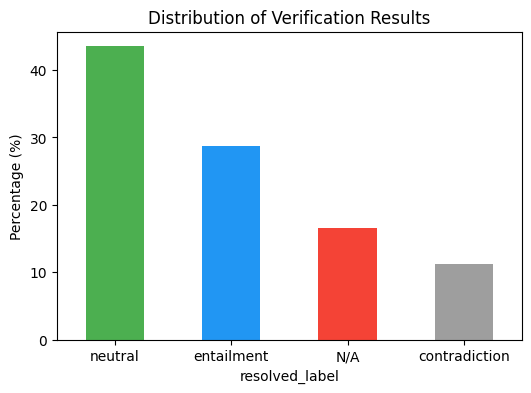

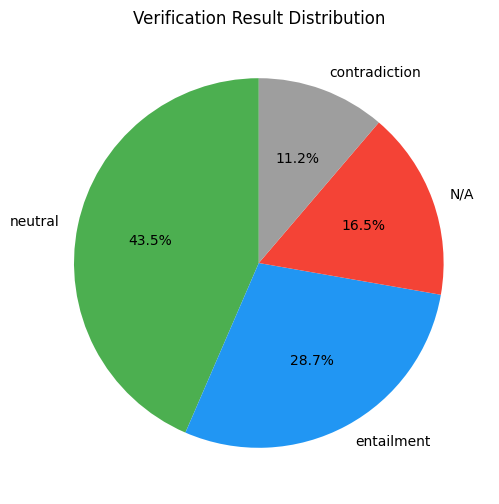

In [37]:
label_counts = final_sample["resolved_label"].value_counts(normalize=True) * 100

# Bar chart
plt.figure(figsize=(6,4))
label_counts.plot(kind="bar", color=["#4caf50","#2196f3","#f44336","#9e9e9e"])
plt.ylabel("Percentage (%)")
plt.title("Distribution of Verification Results")
plt.xticks(rotation=0)
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
label_counts.plot(kind="pie", autopct='%1.1f%%', startangle=90,
                  colors=["#4caf50","#2196f3","#f44336","#9e9e9e"])
plt.ylabel("")
plt.title("Verification Result Distribution")
plt.show()


In [22]:
neutral_cases = final_sample[final_sample["resolved_label"] == "neutral"]
contradiction_cases = final_sample[final_sample["resolved_label"] == "contradiction"]
entailment_cases = final_sample[final_sample["resolved_label"] == "entailment"]


In [41]:
def show_examples(df, label, n=3):
    print(f"\n===== Example {label.title()} Cases =====\n")
    sample_df = df.sample(min(n, len(df)), random_state=42)[
        ["ambiguous_question", "llm_response", "atomic_facts", "knowledge"]
    ]
    for idx, row in sample_df.iterrows():
        print(f"Question: {row['ambiguous_question']}")
        print(f"LLM Response: {row['llm_response']}")
        print(f"Atomic Fact(s): {row['atomic_facts']}")
        print(f" Source Knowledge: {row['knowledge']}\n")
        print("-"*133)

# Show 3 examples from each
show_examples(neutral_cases, "neutral")
show_examples(contradiction_cases, "contradiction")
show_examples(entailment_cases, "entailment")



===== Example Neutral Cases =====

Question: When does the how to train your dragon 3 movie come out?
LLM Response: Answer:
    The How to Train Your Dragon 3 movie was released on June 15, 2019.
Atomic Fact(s): ['The How to Train Your Dragon 3 movie was released on June 15, 2019']
 Source Knowledge: How to Train Your Dragon: The Hidden World is a 2019 American computer-animated action fantasy film loosely based on the book series of the same name by Cressida Cowell. Produced by DreamWorks Animation and distributed by Universal Pictures, it is the sequel to How to Train Your Dragon 2 (2014) and the third and final installment in the How to Train Your Dragon trilogy.[4]

-------------------------------------------------------------------------------------------------------------------------------------
Question: What process releases nitrogen gas into the atmosphere?
LLM Response: Answer:
    Nitrogen gas is released into the atmosphere through a process called denitrification. This pr

In [26]:


def clean_confidence(val):
    # Convert string repr to Python object
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
        except:
            return np.nan
    else:
        parsed = val

    # If it's already a list
    if isinstance(parsed, list):
        # Filter only floats
        nums = [float(x) for x in parsed if str(x).replace('.','',1).isdigit()]
        return np.mean(nums) if nums else np.nan
    
    # If it's a single float
    try:
        return float(parsed)
    except:
        return np.nan

# Apply cleaning
final_sample["confidence_clean"] = final_sample["confidence"].apply(clean_confidence)

# Now try grouping
print(final_sample.groupby("resolved_label")["confidence_clean"].mean())


resolved_label
N/A                   NaN
contradiction    0.725652
entailment       0.815766
neutral          0.827150
Name: confidence_clean, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


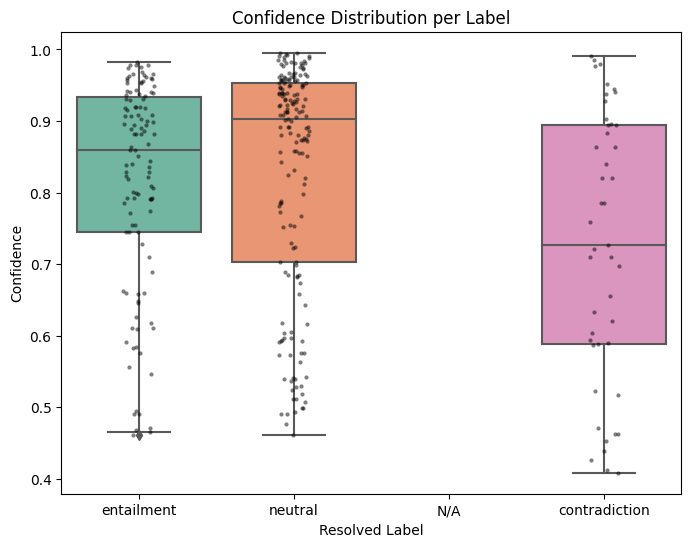

In [27]:
plt.figure(figsize=(8,6))
sns.boxplot(data=final_sample, x="resolved_label", y="confidence_clean", palette="Set2")
sns.stripplot(data=final_sample, x="resolved_label", y="confidence_clean", 
              color="black", size=3, jitter=True, alpha=0.5)

plt.title("Confidence Distribution per Label")
plt.ylabel("Confidence")
plt.xlabel("Resolved Label")
plt.show()


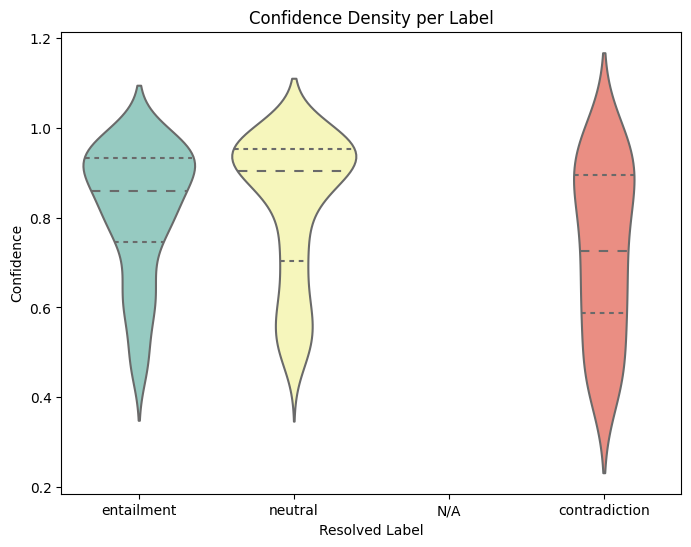

In [28]:
plt.figure(figsize=(8,6))
sns.violinplot(data=final_sample, x="resolved_label", y="confidence_clean", 
               palette="Set3", inner="quartile")

plt.title("Confidence Density per Label")
plt.ylabel("Confidence")
plt.xlabel("Resolved Label")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

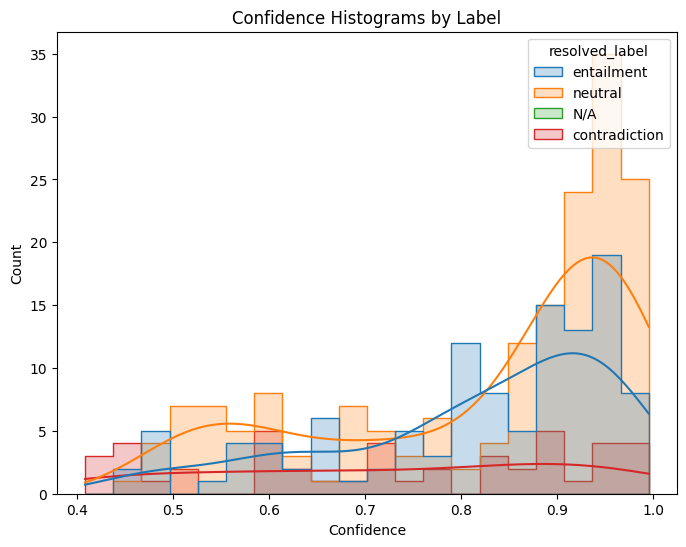

In [29]:
plt.figure(figsize=(8,6))
sns.histplot(data=final_sample, x="confidence_clean", hue="resolved_label", 
             bins=20, kde=True, element="step", common_norm=False)

plt.title("Confidence Histograms by Label")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


In [30]:
from scipy import stats

entail_conf = final_sample[final_sample["resolved_label"]=="entailment"]["confidence_clean"].dropna()
neutral_conf = final_sample[final_sample["resolved_label"]=="neutral"]["confidence_clean"].dropna()
contr_conf = final_sample[final_sample["resolved_label"]=="contradiction"]["confidence_clean"].dropna()


In [31]:
f_stat, p_val = stats.f_oneway(entail_conf, neutral_conf, contr_conf)
print("ANOVA F-stat:", f_stat, "p-value:", p_val)


ANOVA F-stat: 7.359389726160353 p-value: 0.000746244696819545


In [32]:
h_stat, p_val = stats.kruskal(entail_conf, neutral_conf, contr_conf)
print("Kruskal-Wallis H-stat:", h_stat, "p-value:", p_val)


Kruskal-Wallis H-stat: 13.165247856189017 p-value: 0.001384212451574507


In [ ]:
!pip install scikit-posthocs


In [35]:
import scikit_posthocs as sp

data = [entail_conf, neutral_conf, contr_conf]
labels = ["entailment", "neutral", "contradiction"]

posthoc = sp.posthoc_dunn(data, p_adjust="bonferroni")
posthoc.index = labels
posthoc.columns = labels
print(posthoc)


               entailment   neutral  contradiction
entailment       1.000000  0.433019       0.045701
neutral          0.433019  1.000000       0.000953
contradiction    0.045701  0.000953       1.000000
